
# Introduction to Pytorch Lightning

* **Author:** PL team
* **License:** CC BY-SA
* **Generated:** 2022-08-15T09:28:49.859904

In this notebook, we'll go over the basics of lightning by preparing models to train on the [MNIST Handwritten Digits dataset](https://en.wikipedia.org/wiki/MNIST_database).

---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/lightning_examples/mnist-hello-world.ipynb)

Give us a ⭐ [on Github](https://www.github.com/PytorchLightning/pytorch-lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/stable/)
| Join us [on Slack](https://www.pytorchlightning.ai/community)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
#! pip install --quiet "pandas" "ipython[notebook]" "torchvision" "setuptools==59.5.0" "torch>=1.8" "torchmetrics>=0.7" "seaborn" "pytorch-lightning>=1.4"

In [4]:
import os

import pandas as pd
import seaborn as sn
import torch
from IPython.core.display import display
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

/tmp/ipykernel_59777/1920170836.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


## Simplest example

Here's the simplest most minimal example with just a training loop (no validation, no testing).

**Keep in Mind** - A `LightningModule` *is* a PyTorch `nn.Module` - it just has a few more helpful features.

In [5]:
class MNISTModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(28 * 28, 10)

    def forward(self, x):
        return torch.relu(self.l1(x.view(x.size(0), -1)))

    def training_step(self, batch, batch_nb):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

By using the `Trainer` you automatically get:
1. Tensorboard logging
2. Model checkpointing
3. Training and validation loop
4. early-stopping

In [6]:
# Init our model
mnist_model = MNISTModel()

# Init DataLoader from MNIST Dataset
train_ds = MNIST(PATH_DATASETS, train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)


In [7]:

# # Initialize a trainer
# trainer = Trainer(
#     accelerator="auto",
#     devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
#     max_epochs=3,
#     callbacks=[TQDMProgressBar(refresh_rate=20)],
# )

# # Train the model ⚡
# trainer.fit(mnist_model, train_loader)

## A more complete MNIST Lightning Module Example

That wasn't so hard was it?

Now that we've got our feet wet, let's dive in a bit deeper and write a more complete `LightningModule` for MNIST...

This time, we'll bake in all the dataset specific pieces directly in the `LightningModule`.
This way, we can avoid writing extra code at the beginning of our script every time we want to run it.

---

### Note what the following built-in functions are doing:

1. [prepare_data()](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html#prepare-data) 💾
    - This is where we can download the dataset. We point to our desired dataset and ask torchvision's `MNIST` dataset class to download if the dataset isn't found there.
    - **Note we do not make any state assignments in this function** (i.e. `self.something = ...`)

2. [setup(stage)](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html#setup) ⚙️
    - Loads in data from file and prepares PyTorch tensor datasets for each split (train, val, test).
    - Setup expects a 'stage' arg which is used to separate logic for 'fit' and 'test'.
    - If you don't mind loading all your datasets at once, you can set up a condition to allow for both 'fit' related setup and 'test' related setup to run whenever `None` is passed to `stage` (or ignore it altogether and exclude any conditionals).
    - **Note this runs across all GPUs and it *is* safe to make state assignments here**

3. [x_dataloader()](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.core.hooks.DataHooks.html#pytorch_lightning.core.hooks.DataHooks.train_dataloader) ♻️
    - `train_dataloader()`, `val_dataloader()`, and `test_dataloader()` all return PyTorch `DataLoader` instances that are created by wrapping their respective datasets that we prepared in `setup()`

In [15]:
class LitMNIST(LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, learning_rate=2e-4):

        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # Define PyTorch model
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )

        self.val_accuracy = Accuracy()
        self.test_accuracy = Accuracy()

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        print("net: ", logits[0])
        print("gt: ", y[0])
        #print("loss: ", loss.item()[0])
        return loss


    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        print("net: ", logits[0])
        print("gt: ", y[0])
        #print("loss: ", loss.item()[0])
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)


    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)


    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)


    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE, num_workers=8)


    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE, num_workers=8)


    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)

In [16]:
BATCH_SIZE=256
model = LitMNIST()
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=3,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | model         | Sequential | 55.1 K
1 | val_accuracy  | Accuracy   | 0     
2 | test_accuracy | Accuracy   | 0     
---------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

net:  tensor([-2.3973, -2.3176, -2.1930, -2.3705, -2.3229, -2.2591, -2.2014, -2.4425,
        -2.2097, -2.3459], device='cuda:0')
gt:  tensor(3, device='cuda:0')
net:  tensor([-2.5265, -2.2175, -2.1996, -2.4547, -2.3955, -2.3318, -2.0913, -2.3965,
        -2.1883, -2.3072], device='cuda:0')
gt:  tensor(0, device='cuda:0')


Training: 0it [00:00, ?it/s]

net:  tensor([-2.3612, -2.2587, -2.1870, -2.4614, -2.3856, -2.4121, -2.0609, -2.3361,
        -2.2503, -2.3799], device='cuda:0', grad_fn=<SelectBackward0>)
gt:  tensor(8, device='cuda:0')
net:  tensor([-2.4702, -2.3652, -2.1485, -2.4009, -2.3506, -2.3651, -2.0484, -2.2807,
        -2.2983, -2.3712], device='cuda:0', grad_fn=<SelectBackward0>)
gt:  tensor(6, device='cuda:0')
net:  tensor([-2.4071, -2.2137, -2.0595, -2.4081, -2.3068, -2.5883, -2.2293, -2.3103,
        -2.1603, -2.4502], device='cuda:0', grad_fn=<SelectBackward0>)
gt:  tensor(0, device='cuda:0')
net:  tensor([-2.2771, -2.3059, -2.3740, -2.3758, -2.3269, -2.3567, -2.2077, -2.1871,
        -2.3226, -2.3111], device='cuda:0', grad_fn=<SelectBackward0>)
gt:  tensor(5, device='cuda:0')
net:  tensor([-2.4491, -2.3809, -2.1209, -2.3488, -2.4145, -2.3791, -2.0693, -2.4061,
        -2.2739, -2.2600], device='cuda:0', grad_fn=<SelectBackward0>)
gt:  tensor(2, device='cuda:0')
net:  tensor([-2.3901, -2.5177, -2.1992, -2.3130, -2.26

Validation: 0it [00:00, ?it/s]

net:  tensor([-4.9166, -7.7174, -2.1013, -0.2469, -8.1937, -4.0035, -7.6998, -9.1797,
        -2.6659, -9.0305], device='cuda:0')
gt:  tensor(3, device='cuda:0')
net:  tensor([-7.5018e-03, -1.3732e+01, -8.1484e+00, -1.0702e+01, -8.7683e+00,
        -7.1964e+00, -5.3962e+00, -6.7921e+00, -8.5972e+00, -7.7878e+00],
       device='cuda:0')
gt:  tensor(0, device='cuda:0')
net:  tensor([ -0.0182, -13.5695,  -8.9199,  -7.9101,  -9.6059,  -4.2217,  -6.1803,
         -9.6872,  -7.5511,  -9.2937], device='cuda:0')
gt:  tensor(0, device='cuda:0')
net:  tensor([-8.5304, -0.0554, -4.3389, -5.3656, -4.8054, -6.2891, -5.8371, -5.8599,
        -4.0131, -6.1687], device='cuda:0')
gt:  tensor(1, device='cuda:0')
net:  tensor([-6.3614, -6.4728, -5.8878, -7.6507, -2.2316, -6.9501, -5.8243, -3.3771,
        -4.5133, -0.1778], device='cuda:0')
gt:  tensor(9, device='cuda:0')
net:  tensor([-4.1493, -7.1580, -5.5953, -0.8184, -5.6019, -0.7685, -5.7827, -5.2854,
        -3.0849, -4.0555], device='cuda:0')
gt:

Validation: 0it [00:00, ?it/s]

net:  tensor([-5.4547, -7.5714, -2.4488, -0.1685, -9.9847, -4.3353, -9.1037, -9.6636,
        -2.9852, -9.7198], device='cuda:0')
gt:  tensor(3, device='cuda:0')
net:  tensor([-1.4231e-03, -1.5845e+01, -9.0542e+00, -1.3167e+01, -1.2253e+01,
        -8.1832e+00, -7.0848e+00, -9.1398e+00, -1.0472e+01, -9.9936e+00],
       device='cuda:0')
gt:  tensor(0, device='cuda:0')
net:  tensor([-2.1442e-03, -1.5598e+01, -1.0334e+01, -1.0928e+01, -1.3398e+01,
        -6.3219e+00, -8.5047e+00, -1.1985e+01, -9.5346e+00, -1.1328e+01],
       device='cuda:0')
gt:  tensor(0, device='cuda:0')
net:  tensor([-10.2393,  -0.0165,  -5.2446,  -6.5444,  -6.5674,  -7.7935,  -6.8913,
         -6.9350,  -5.2271,  -7.8418], device='cuda:0')
gt:  tensor(1, device='cuda:0')
net:  tensor([-8.2400, -8.9016, -6.9807, -8.9935, -3.5966, -8.9248, -7.6215, -4.8778,
        -5.4513, -0.0423], device='cuda:0')
gt:  tensor(9, device='cuda:0')
net:  tensor([-4.8293, -7.9200, -6.8291, -0.9065, -6.8064, -0.6047, -7.3799, -6.1488,


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


net:  tensor([ -5.5760,  -7.7459,  -2.6986,  -0.1395, -10.7056,  -4.1027,  -9.4567,
         -9.7814,  -3.1702,  -9.9553], device='cuda:0')
gt:  tensor(3, device='cuda:0')
net:  tensor([-9.5429e-04, -1.5782e+01, -8.9699e+00, -1.3864e+01, -1.3271e+01,
        -8.4687e+00, -7.6155e+00, -9.6461e+00, -1.0907e+01, -1.0171e+01],
       device='cuda:0')
gt:  tensor(0, device='cuda:0')
net:  tensor([-7.3823e-04, -1.6301e+01, -1.0656e+01, -1.2344e+01, -1.4934e+01,
        -7.4603e+00, -9.2029e+00, -1.2988e+01, -1.0641e+01, -1.1856e+01],
       device='cuda:0')
gt:  tensor(0, device='cuda:0')
net:  tensor([-1.0861e+01, -1.0745e-02, -5.7157e+00, -6.8705e+00, -7.4962e+00,
        -8.3211e+00, -7.2975e+00, -7.0547e+00, -5.5747e+00, -8.4942e+00],
       device='cuda:0')
gt:  tensor(1, device='cuda:0')
net:  tensor([-9.0659, -9.6869, -7.5369, -9.3295, -4.3368, -9.9537, -8.7489, -5.4431,
        -5.8543, -0.0215], device='cuda:0')
gt:  tensor(9, device='cuda:0')
net:  tensor([-5.4377, -8.5731, -7.6044

### Testing

To test a model, call `trainer.test(model)`.

Or, if you've just trained a model, you can just call `trainer.test()` and Lightning will automatically
test using the best saved checkpoint (conditioned on val_loss).

In [17]:
trainer.test()

/home/ibad/venvs/deeply/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1388: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at logs/lightning_logs/version_6/checkpoints/epoch=2-step=645.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/lightning_logs/version_6/checkpoints/epoch=2-step=645.ckpt
/home/ibad/venvs/deeply/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9247999787330627
        test_loss            0.252829372882843
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.252829372882843, 'test_acc': 0.9247999787330627}]

### Bonus Tip

You can keep calling `trainer.fit(model)` as many times as you'd like to continue training

In [18]:
trainer.fit(model)

/home/ibad/venvs/deeply/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory logs/lightning_logs/version_6/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | model         | Sequential | 55.1 K
1 | val_accuracy  | Accuracy   | 0     
2 | test_accuracy | Accuracy   | 0     
---------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


net:  tensor([-8.1063, -8.9054, -6.4871, -6.3289, -0.1027, -5.6391, -6.7135, -5.0987,
        -6.7823, -2.5031], device='cuda:0')
gt:  tensor(4, device='cuda:0')
net:  tensor([-1.1054e+01, -9.7297e+00, -1.1170e+01, -7.3367e+00, -8.9597e+00,
        -9.2121e+00, -1.3955e+01, -9.1094e-03, -9.1594e+00, -4.8292e+00],
       device='cuda:0')
gt:  tensor(7, device='cuda:0')


In Colab, you can use the TensorBoard magic function to view the logs that Lightning has created for you!

,val_loss,val_acc,test_loss,test_acc
epoch,,,,
0,0.426161,0.8906,NaN,NaN
1,0.309472,0.9078,NaN,NaN
2,0.261269,0.9212,NaN,NaN
2,NaN,NaN,0.252829,0.9248


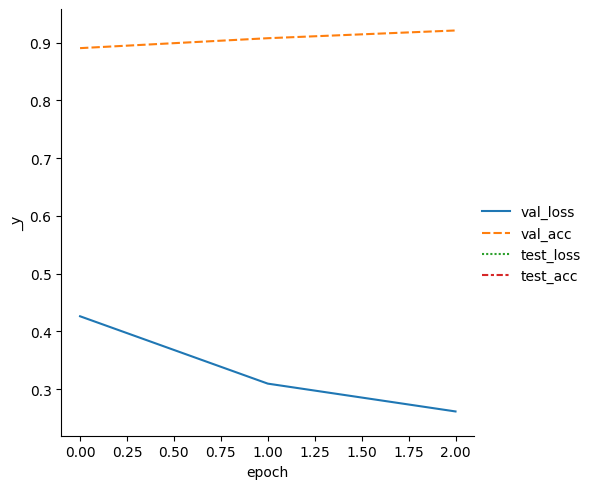

In [19]:

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Slack](https://www.pytorchlightning.ai/community)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/PyTorchLightning/pytorch-lightning) or [Bolt](https://github.com/PyTorchLightning/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/PyTorchLightning/pytorch-lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/PyTorchLightning/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[Pytorch Lightning{height="60px" width="240px"}](https://pytorchlightning.ai)